In [1]:
import os
import sys
sys.path.append('/home/yang_liu/python_workspace/gaussian-splatting-lightning')

import json
import pickle
import torch
import alphashape
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from plyfile import PlyData, PlyElement

## 1. Average Distance Analysis & Downsampling & Saving

In [2]:
import open3d as o3d
file_dir = '../data/GauU_Scene/CUHK_UPPER_COLMAP/cuhksz_upper_campus.ply'
pcd = o3d.io.read_point_cloud(file_dir)
print(len(pcd.points))
print(np.mean(pcd.compute_nearest_neighbor_distance()))
# print(np.std(pcd.compute_nearest_neighbor_distance()))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
94218901
0.00161036605693424


In [ ]:
ds_pcd = pcd.voxel_down_sample(voxel_size=0.001)
print(np.mean(ds_pcd.compute_nearest_neighbor_distance()))

0.00374213310569026


In [6]:
# save the downsampled point cloud
save_dir = file_dir.replace(".ply", "_ds.ply")
print(save_dir)
o3d.io.write_point_cloud(save_dir, ds_pcd)

True

## 2. Show Spatial Distribution

In [10]:
file_dir = '../data/GauU_Scene/LFLS/LFLS_ds.ply'
transform_dir = '../data/GauU_Scene/Downsampled/LFLS/transform.txt'
plydata = PlyData.read(file_dir)
data = plydata.elements[0].data
data_pd = pd.DataFrame(data)
data_np = np.zeros(data_pd.shape, dtype=np.float32)
property_names = data[0].dtype.names
for i, name in enumerate(property_names):
    data_np[:, i] = data_pd[name]

In [11]:
from scipy.spatial import ConvexHull
# MatrixCity
# filtered_pcd = data_np[data_np[:, 2] > 0.0]
# color = filtered_pcd[:, 6:9] / 255.0
# GauU-Scene
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)
filtered_pcd = data_np
xyz_homo = np.concatenate([filtered_pcd[:, :3], np.ones_like(filtered_pcd[:, :1])], axis=-1)
filtered_pcd[:, :3] = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]
color = filtered_pcd[:, 6:9] / 255.0

In [18]:
# hull = ConvexHull(filtered_pcd[:, :2], 'Qg')
hull = alphashape.alphashape(filtered_pcd[::100, :2], alpha=1.0)
x, y = hull.exterior.xy

14919419


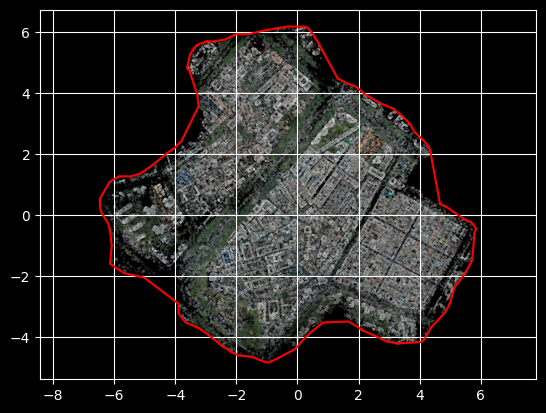

In [19]:
print(data_np.shape[0])
plt.figure()
plt.scatter(filtered_pcd[::100, 0], filtered_pcd[::100, 1], s=0.01, c=color[::100])
# plt.plot(filtered_pcd[hull_list + [hull_list[0]], 0], filtered_pcd[hull_list + [hull_list[0]], 1], 'r-')
plt.plot(x, y, 'r-')
plt.grid()
plt.axis('equal')
plt.show()

In [17]:
print(f"Z min: {np.min(filtered_pcd[:, 2])}, Z max: {np.max(filtered_pcd[:, 2])}")
# for idx in hull_list:
#     print(f"[ {filtered_pcd[idx, 0]}, {filtered_pcd[idx, 1]}, 0.0 ],")
for idx in range(len(x)):
    print(f"[ {x[idx]}, {y[idx]}, 0.0 ],")

Z min: 0.5662662386894226, Z max: 2.4628875255584717
[ -1.428504228591919, 5.963998317718506, 0.0 ],
[ -1.167250156402588, 6.027939319610596, 0.0 ],
[ -0.6984825134277344, 6.100508689880371, 0.0 ],
[ -0.6699308753013611, 6.1207756996154785, 0.0 ],
[ -0.6546247005462646, 6.124993324279785, 0.0 ],
[ -0.4926316738128662, 6.144198894500732, 0.0 ],
[ -0.33221137523651123, 6.177433490753174, 0.0 ],
[ -0.13229356706142426, 6.115106582641602, 0.0 ],
[ 0.16262872517108917, 6.130815505981445, 0.0 ],
[ 0.26148003339767456, 6.169567108154297, 0.0 ],
[ 0.3215795159339905, 6.145153045654297, 0.0 ],
[ 0.469341903924942, 5.980937480926514, 0.0 ],
[ 0.7305672764778137, 5.566352367401123, 0.0 ],
[ 0.7458255290985107, 5.521495819091797, 0.0 ],
[ 0.7373266220092773, 5.418566703796387, 0.0 ],
[ 0.7686046957969666, 5.132166862487793, 0.0 ],
[ 1.3146405220031738, 4.482467174530029, 0.0 ],
[ 1.3472627401351929, 4.464902400970459, 0.0 ],
[ 1.442705750465393, 4.408787250518799, 0.0 ],
[ 1.653770923614502, 4.298

## 3. Compare Point Clouds

In [31]:
import open3d as o3d

pcd_path = '../outputs/citygs2d_lfls_coarse_lnorm8_wo_vast/mesh/epoch=32-step=30000/evaluation/pcd.ply'
gt_pcd_path = '../outputs/citygs2d_lfls_coarse_lnorm8_wo_vast/mesh/epoch=32-step=30000/evaluation/gt_pcd.ply'
# ref_path = "../outputs/citygs_flatten_lfls_coarse/mesh/epoch=32-step=30000/evaluation/pcd.ply"
pcd = o3d.io.read_point_cloud(pcd_path)
gt_pcd = o3d.io.read_point_cloud(gt_pcd_path)
# ref_pcd = o3d.io.read_point_cloud(ref_path)

In [28]:
transform_dir = '../data/GauU_Scene/Downsampled/SMBU/transform.txt'
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)
pcd.transform(np.linalg.inv(transform))
gt_pcd.transform(np.linalg.inv(transform))

PointCloud with 14919419 points.

16607943
14919419


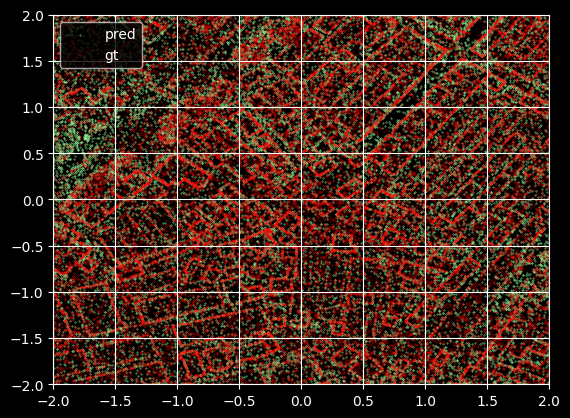

In [32]:
plt.figure()
# print(len(ref_pcd.points))
print(len(pcd.points))
print(len(gt_pcd.points))
# plt.scatter(np.array(ref_pcd.points)[::100, 0], np.array(ref_pcd.points)[::100, 2], s=0.1, label='ref', c='r')
plt.scatter(np.array(pcd.points)[::100, 0], np.array(pcd.points)[::100, 1], s=0.1, label='pred', c='lightgreen')
plt.scatter(np.array(gt_pcd.points)[::100, 0], np.array(gt_pcd.points)[::100, 1], s=0.05, label='gt', c='red')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.legend()

## 4. Analyze Checkpoints

In [5]:
file_dir = '../data/GauU_Scene/LFLS/LFLS_ds_35.ply'
plydata = PlyData.read(file_dir)
data = plydata.elements[0].data
data_pd = pd.DataFrame(data)
data_np = np.zeros(data_pd.shape, dtype=np.float32)
property_names = data[0].dtype.names
for i, name in enumerate(property_names):
    data_np[:, i] = data_pd[name]

x_min, x_max = np.min(data_np[:, 0]), np.max(data_np[:, 0])
y_min, y_max = np.min(data_np[:, 1]), np.max(data_np[:, 1])

In [16]:
transform_dir = '../data/GauU_Scene/Downsampled/LFLS/transform.txt'
with open(transform_dir, 'r') as f:
    transform = np.loadtxt(f)
xyz_homo = np.concatenate([data_np[:, :3], np.ones_like(data_np[:, :1])], axis=-1)
data_np_pcd = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]

In [7]:
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.utils.sh_utils import SH2RGB
# load model and dataset
ckpt_path = '../outputs/citygs2d_lfls_lnorm8_wo_vast_sep_depth/checkpoints/epoch=32-step=30000.ckpt'
model, renderer = GaussianModelLoader.search_and_load(
    ckpt_path,
    sh_degree=3,
    device="cuda",
)
if isinstance(renderer, VanillaTrimRenderer):
    model._scaling = torch.cat((torch.ones_like(model._scaling[:, :1]) * 1e-8, model._scaling[:, [-2, -1]]), dim=1)

In [8]:
ckpt_path_coarse = '../outputs/citygs2d_lfls_coarse_lnorm8_wo_vast_sep_depth_init_5/checkpoints/epoch=32-step=30000.ckpt'
model_coarse, renderer = GaussianModelLoader.search_and_load(
    ckpt_path_coarse,
    sh_degree=3,
    device="cuda",
)
if isinstance(renderer, VanillaTrimRenderer):
    model_coarse._scaling = torch.cat((torch.ones_like(model_coarse._scaling[:, :1]) * 1e-8, model_coarse._scaling[:, [-2, -1]]), dim=1)

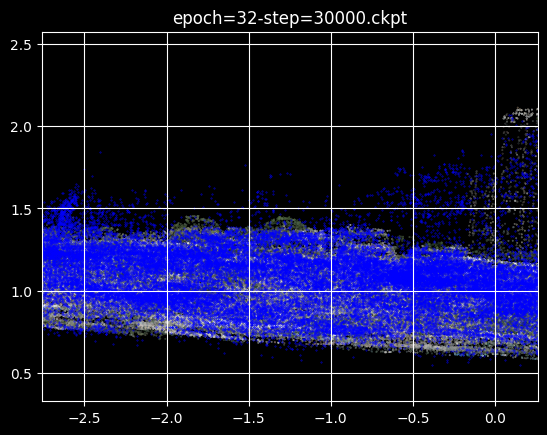

: 

In [22]:
plt.figure()
xyz = model.get_xyz.cpu().numpy()
xyz_coarse = model_coarse.get_xyz.cpu().numpy()

xyz_homo = np.concatenate([xyz[:, :3], np.ones_like(xyz[:, :1])], axis=-1)
xyz[:, :3] = (xyz_homo @ np.linalg.inv(transform).T)[:, :3]

xyz_coarse_homo = np.concatenate([xyz_coarse[:, :3], np.ones_like(xyz_coarse[:, :1])], axis=-1)
xyz_coarse[:, :3] = (xyz_coarse_homo @ np.linalg.inv(transform).T)[:, :3]

plt.scatter(data_np_pcd[::100, 0], data_np_pcd[::100, 2], s=0.1, c=data_np[::100, 3:6] / 255.0)
# plt.scatter(xyz[::100, 0], xyz[::100, 2], s=0.1, c='r')
plt.scatter(xyz_coarse[::100, 0], xyz_coarse[::100, 2], s=0.1, c='b')
plt.axis('equal')
plt.xlim(-2.5, 0)
# plt.ylim(-4, 0)
plt.title(ckpt_path.split('/')[-1])
plt.grid()
plt.show()

Gaussian count of ../data/GauU_Scene/LFLS/LFLS_ds.ply: 3743191
Max ratio: 1.0, Min ratio: 0.0010196679504588246


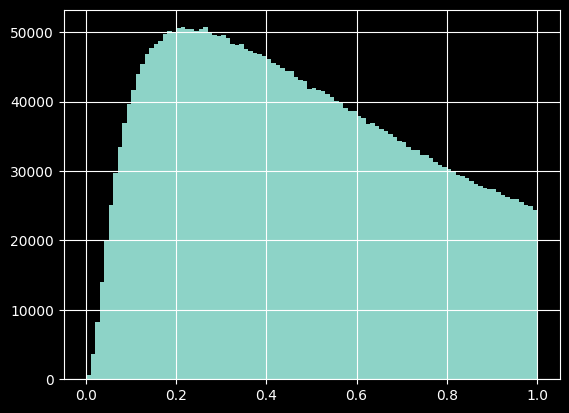

In [81]:
scaling = model.get_scaling
sorted_scaling = scaling.sort(dim=-1)[0]
ratio = sorted_scaling[:, 1] / sorted_scaling[:, 2]
print("Gaussian count of {}: {}".format(file_dir, model.get_xyz.shape[0]))
print(f"Max ratio: {ratio.max().item()}, Min ratio: {ratio.min().item()}")
plt.figure()
plt.hist(ratio.cpu().numpy(), bins=100)
plt.grid()
plt.show()